In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.preprocessing import LabelEncoder


from keras.layers import Input, Add, Dense, Conv2D, MaxPool2D, GlobalMaxPooling2D, BatchNormalization, Activation, Flatten, ZeroPadding2D, GlobalAveragePooling2D, Dot, Reshape, Conv1D, Concatenate,Multiply, Lambda, UpSampling2D, AveragePooling2D, MaxPooling2D,Dropout
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.layers import Layer
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from time import time
from PIL import Image

import os
import random
import glob

In [2]:
#Training and Test Data path
data_path = "C:\\Users\\User\\Downloads\\cvpr10Data"

training_path = os.path.join(data_path, 'training')
testing_path = os.path.join(data_path,"testing")

train_frames_npy = os.path.join(training_path, 'train_frames_npy')
train_masks_npy = os.path.join(training_path, 'train_masks_npy')

test_frames_npy = os.path.join(testing_path, 'test_frames_npy')
test_masks_npy = os.path.join(testing_path, 'test_masks_npy')

In [3]:
def my_data_gen(img_folder, mask_folder, batch_size):
    c = 0
    n = os.listdir(img_folder)
    random.shuffle(n)
    
    while(True):
        img = np.zeros((batch_size,256,256,3)).astype('uint8') #uint8: Unsigned integer (0 to 255)
        mask = np.zeros((batch_size,256, 256, 8))
        
        for i in range(c,c+batch_size):
            train_img = np.load(img_folder + f"\\{n[i]}")
            train_img = cv2.resize(train_img, (256,256))

            img[i-c] = train_img
            
            train_mask = np.load(mask_folder + f"\\{n[i]}")
            train_mask = cv2.resize(train_mask, (256,256), interpolation = cv2.INTER_NEAREST)
            train_mask = to_categorical(train_mask, num_classes = 8)
            
            mask[i-c] = train_mask
        
        c+=batch_size
        if (c+batch_size >= len(os.listdir(img_folder))):
            c = 0
            random.shuffle(n)
            
        yield img,mask
    
train_gen = my_data_gen(train_frames_npy, train_masks_npy,16)
val_gen = my_data_gen(test_frames_npy, test_masks_npy,16) 

In [4]:
# Defining Self-attention block
def self_attention(input_feature, num_channel, base):

    """
    Function arguments:
    1. input_feature: Input to the self-attention block.
    2. num_channel: Number of channels after the dense operation.
    3. base: layer name identifier.
    """

    bn_1 = BatchNormalization(axis = -1, name = base + '/bn_1')(input_feature)
    dense_1 = Dense(num_channel, name = base + '/dense_1')(bn_1)
    act_1 = Activation('relu', name = base + '/act_1')(dense_1)

    bn_2 = BatchNormalization(axis = -1, name = base + '/bn_2')(input_feature)
    dense_2 = Dense(num_channel, name = base + '/dense_2')(bn_2)
    act_2 = Activation('relu', name = base + '/act_2')(dense_2)

    bn_3 = BatchNormalization(axis = -1, name = base + '/bn_3')(input_feature)
    dense_3 = Dense(num_channel, name = base + '/dense_3')(bn_3)
    act_3 = Activation('relu', name = base + '/act_3')(dense_3)

    mul_1 = Multiply(name = base + '/mul_1')([act_2, act_3])
    mask_part = Activation('softmax', name = base + '/act_4')(mul_1)
    mul_2 = Multiply(name = base + '/mul_2')([act_1, mask_part])

    output_feature = Add(name = base + '/add_1')([mul_2, input_feature])

    return output_feature


# Batch of multi-feature attention module
def BMFA(input_feature, num_channel, base):

    """
    Function arguments:
    1. input_feature: Input to the BMFA module.
    2. num_channel: Number of channels after the dense operation.
    3. base: layer name identifier.
    """
    out_1 = self_attention(input_feature, num_channel, base + '/self_att_1')
    out_2 = self_attention(input_feature, num_channel, base + '/self_att_2')
    out_3 = self_attention(input_feature, num_channel, base + '/self_att_3')

    output_feature = Add(name = base + '/add')([out_1, out_2, out_3])

    return output_feature

# Parallel excitation module
def PEM(input_feature, num_channel, base):

    """
    Function arguments:
    1. input_feature: Input to the PEM module.
    2. num_channel: Number of channels after the convolution operation.
    3. base: layer name identifier.
    """

    # Channel attention
    GAP_output = GlobalAveragePooling2D(name = base + '/gap_layer')(input_feature)
    
    bn_1 = BatchNormalization(axis = -1, name = base + '/bn_1')(GAP_output)
    dense_1 = Dense(int(num_channel/4), name = base + '/dense_1')(bn_1)
    act_1 = Activation('relu', name = base + '/act_1')(dense_1)
    
    bn_2 = BatchNormalization(axis = -1, name = base + '/bn_2')(act_1)
    dense_2 = Dense(num_channel, name = base + '/dense_2')(bn_2)
    
    act_2 = Activation('sigmoid', name = base + '/act_2')(dense_2)
    
    out_channel = Multiply(name = base + '/mul_1')([act_2, input_feature])
    
    # Spatial attention
    strides = (1,1)

    bn_3 = BatchNormalization(axis = -1, name = base + '/bn_3')(input_feature)
    cn_3 = Conv2D(num_channel, (3,3), strides = strides, padding = 'same', name = base + '/conv_1')(bn_3)
    an_3 = Activation('relu', name = base + '/act_3')(cn_3)

    bn_4 = BatchNormalization(axis = -1, name = base + '/bn_4')(an_3)
    cn_4 = Conv2D(1, (1,1), strides = strides, padding = 'same', name = base + '/conv_2')(bn_4)
    cn_4 = Add(name = base + '/sp_add')([input_feature, cn_4])
    
    an_4 = Activation('sigmoid', name = base + '/act_4')(cn_4)

    out_spatial = Multiply(name = base + '/mul_2')([an_4, input_feature])

    output_response = Add(name = base + '/add')([input_feature, out_channel, out_spatial])

    return output_response

#SDAM implementation
def SDAM(input_feature, num_channel, base):
    output_response_PEM = PEM(input_feature, num_channel, base+'_PEM')
    output_feature_BMFA =  BMFA(input_feature, num_channel, base+'_BMFA')
    output_response = Add(name = base + '/add')([output_response_PEM, output_feature_BMFA])
    
    return output_response
    

# Defining Residual Module
def residual_block(input_feature, num_channel, base):

    """
    Function arguments:
    1. input_feature: Input to the residual block.
    2. num_channel: Number of channels after the convolution operation.
    3. base: layer name identifier.
    """

    strides = (1,1)

    bn_1 = BatchNormalization(axis = -1, name = base + '/bn_1')(input_feature)
    cn_1 = Conv2D(num_channel, (1,1), strides = strides, padding = 'same', name = base + '/conv_1')(bn_1)
    an_1 = Activation('relu', name = base + '/act_1')(cn_1)
    

    bn_2 = BatchNormalization(axis = -1, name = base + '/bn_2')(an_1)
    cn_2 = Conv2D(num_channel, (3,3), strides = strides, padding = 'same', name = base + '/conv_2')(bn_2)
    an_2 = Activation('relu', name = base + '/act_2')(cn_2)

    bn_3 = BatchNormalization(axis = -1, name = base + '/bn_3')(an_2)
    cn_3 = Conv2D(num_channel, (1,1), strides = strides, padding = 'same', name = base + '/conv_3')(bn_3)
    an_3 = Activation('relu', name = base + '/act_3')(cn_3)

    output_feature = Add(name = base + '/add')([input_feature, an_3])
    
    return output_feature




In [5]:
with tf.device('/cpu:0'):
    def attention_model(n_filters = 16, bn = True, dilation_rate = 1, batch_size = 16):
        inputs = Input(batch_shape=(batch_size, 256, 256, 3))
        conv1 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(inputs)
        res1 = residual_block(conv1, n_filters * 1, 'base_res1')
        pool1 = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(res1)
        
        conv2 = Conv2D(n_filters * 2, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(pool1)
        res2 = residual_block(conv2, n_filters * 2, 'base_res2')
        
        sdam1 = SDAM(res2, n_filters *2, 'base_SDAM_1')
        
        up1 = UpSampling2D(size=(2, 2))(sdam1)
        conv3 = Conv2D(n_filters * 1, (3, 3), activation='relu', padding = 'same', dilation_rate = dilation_rate)(up1)
        res3 = residual_block(conv3, n_filters * 1, 'base_res3')
        
        finaloutput = Dense(units=8, activation='sigmoid', name='final')(res3)
        model = Model(inputs=inputs, outputs=finaloutput)
        return model

    batch_size = 16
    model = attention_model(n_filters = 32, batch_size = batch_size)

    model.summary()

(16, 128, 128, 64)
(16, 64)
(16, 64)
(16, 16)
(16, 16)
(16, 16)
(16, 64)
(16, 64)
(16, 128, 128, 64)
(16, 128, 128, 64)
(16, 128, 128, 64)
(16, 128, 128, 64)
(16, 128, 128, 64)
(16, 128, 128, 1)
(16, 128, 128, 64)
(16, 128, 128, 64)
(16, 128, 128, 64)
(16, 128, 128, 64)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(16, 256, 256, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (16, 256, 256, 32)   896         ['input_1[0][0]']                
                                                                                                  
 base_res1/bn_1 (BatchNormaliza  (16, 256, 256, 32)  128         ['conv2d[0][0]']                 
 tion)               

 base_SDAM_1_BMFA/self_att_2/bn  (16, 128, 128, 64)  256         ['base_res2/add[0][0]']          
 _3 (BatchNormalization)                                                                          
                                                                                                  
 base_SDAM_1_BMFA/self_att_3/bn  (16, 128, 128, 64)  256         ['base_res2/add[0][0]']          
 _2 (BatchNormalization)                                                                          
                                                                                                  
 base_SDAM_1_BMFA/self_att_3/bn  (16, 128, 128, 64)  256         ['base_res2/add[0][0]']          
 _3 (BatchNormalization)                                                                          
                                                                                                  
 base_SDAM_1_PEM/dense_1 (Dense  (16, 16)            1040        ['base_SDAM_1_PEM/bn_1[0][0]']   
 )        

 base_SDAM_1_BMFA/self_att_2/mu  (16, 128, 128, 64)  0           ['base_SDAM_1_BMFA/self_att_2/act
 l_1 (Multiply)                                                  _2[0][0]',                       
                                                                  'base_SDAM_1_BMFA/self_att_2/act
                                                                 _3[0][0]']                       
                                                                                                  
 base_SDAM_1_BMFA/self_att_3/de  (16, 128, 128, 64)  4160        ['base_SDAM_1_BMFA/self_att_3/bn_
 nse_1 (Dense)                                                   1[0][0]']                        
                                                                                                  
 base_SDAM_1_BMFA/self_att_3/mu  (16, 128, 128, 64)  0           ['base_SDAM_1_BMFA/self_att_3/act
 l_1 (Multiply)                                                  _2[0][0]',                       
          

                                                                 _1[0][0]',                       
                                                                  'base_SDAM_1_BMFA/self_att_3/add
                                                                 _1[0][0]']                       
                                                                                                  
 base_SDAM_1/add (Add)          (16, 128, 128, 64)   0           ['base_SDAM_1_PEM/add[0][0]',    
                                                                  'base_SDAM_1_BMFA/add[0][0]']   
                                                                                                  
 up_sampling2d (UpSampling2D)   (16, 256, 256, 64)   0           ['base_SDAM_1/add[0][0]']        
                                                                                                  
 conv2d_2 (Conv2D)              (16, 256, 256, 32)   18464       ['up_sampling2d[0][0]']          
          

In [6]:
#model evaluation performance matrics 

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

smooth = 1

with tf.device('/cpu:0'):
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[dice_coef,'accuracy', iou_coef])

    mc = ModelCheckpoint(mode='max', filepath='att_model_9010.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
    es = EarlyStopping(mode='max', monitor='val_accuracy', patience=10, verbose=1)
    log_csv = CSVLogger('mylogs_att_9010.csv',separator=',', append=False)
    callbacks = [mc,log_csv]



In [17]:
num_epochs = 100

with tf.device('/gpu:0'):
    result = model.fit(train_gen, steps_per_epoch=int(400/batch_size) ,
                 epochs=num_epochs, callbacks=callbacks,validation_data = val_gen,
                            validation_steps = int(134/batch_size))

    
    

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.7962 - dice_coef: 0.4914 - accuracy: 0.4554 - iou_coef: 0.2860
Epoch 1: accuracy improved from 0.32484 to 0.45539, saving model to att_model_9010.h5
25/25 [==============================] - 8s 318ms/step - loss: 0.7962 - dice_coef: 0.4914 - accuracy: 0.4554 - iou_coef: 0.2860 - val_loss: 0.9754 - val_dice_coef: 0.4012 - val_accuracy: 0.2995 - val_iou_coef: 0.2205
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.5393 - dice_coef: 0.5423 - accuracy: 0.5130 - iou_coef: 0.3137
Epoch 2: accuracy improved from 0.45539 to 0.51302, saving model to att_model_9010.h5
25/25 [==============================] - 8s 316ms/step - loss: 0.5393 - dice_coef: 0.5423 - accuracy: 0.5130 - iou_coef: 0.3137 - val_loss: 0.7521 - val_dice_coef: 0.3690 - val_accuracy: 0.3070 - val_iou_coef: 0.1910
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.4327 - dice_coef: 0.5835 - accuracy: 0.5633 - iou_coef:

Epoch 40/100
25/25 [==============================] - ETA: 0s - loss: 0.1419 - dice_coef: 0.8133 - accuracy: 0.7901 - iou_coef: 0.5405
Epoch 40: accuracy did not improve from 0.81644
25/25 [==============================] - 8s 313ms/step - loss: 0.1419 - dice_coef: 0.8133 - accuracy: 0.7901 - iou_coef: 0.5405 - val_loss: 0.1294 - val_dice_coef: 0.8306 - val_accuracy: 0.8125 - val_iou_coef: 0.5678
Epoch 41/100
25/25 [==============================] - ETA: 0s - loss: 0.1298 - dice_coef: 0.8326 - accuracy: 0.8127 - iou_coef: 0.5675
Epoch 41: accuracy did not improve from 0.81644
25/25 [==============================] - 8s 311ms/step - loss: 0.1298 - dice_coef: 0.8326 - accuracy: 0.8127 - iou_coef: 0.5675 - val_loss: 0.1197 - val_dice_coef: 0.8520 - val_accuracy: 0.8289 - val_iou_coef: 0.6245
Epoch 42/100
25/25 [==============================] - ETA: 0s - loss: 0.1332 - dice_coef: 0.8277 - accuracy: 0.8050 - iou_coef: 0.5662
Epoch 42: accuracy did not improve from 0.81644
25/25 [==========

25/25 [==============================] - ETA: 0s - loss: 0.1139 - dice_coef: 0.8553 - accuracy: 0.8330 - iou_coef: 0.6160
Epoch 80: accuracy did not improve from 0.83760
25/25 [==============================] - 8s 310ms/step - loss: 0.1139 - dice_coef: 0.8553 - accuracy: 0.8330 - iou_coef: 0.6160 - val_loss: 0.1153 - val_dice_coef: 0.8564 - val_accuracy: 0.8385 - val_iou_coef: 0.6118
Epoch 81/100
25/25 [==============================] - ETA: 0s - loss: 0.1112 - dice_coef: 0.8609 - accuracy: 0.8382 - iou_coef: 0.6226
Epoch 81: accuracy improved from 0.83760 to 0.83821, saving model to att_model_9010.h5
25/25 [==============================] - 8s 314ms/step - loss: 0.1112 - dice_coef: 0.8609 - accuracy: 0.8382 - iou_coef: 0.6226 - val_loss: 0.1092 - val_dice_coef: 0.8695 - val_accuracy: 0.8531 - val_iou_coef: 0.6432
Epoch 82/100
25/25 [==============================] - ETA: 0s - loss: 0.1149 - dice_coef: 0.8539 - accuracy: 0.8309 - iou_coef: 0.6109
Epoch 82: accuracy did not improve from

1/1 [==============================] - 0s 88ms/step


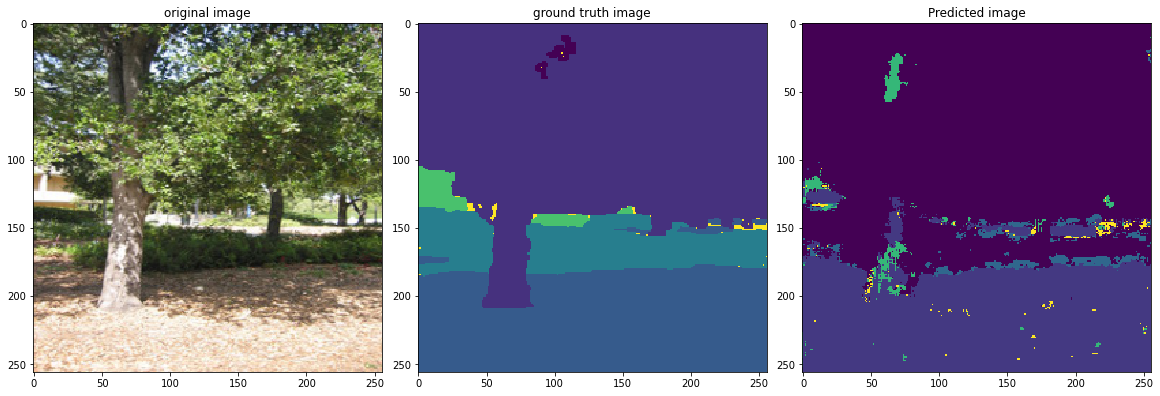

1/1 [==============================] - 0s 93ms/step


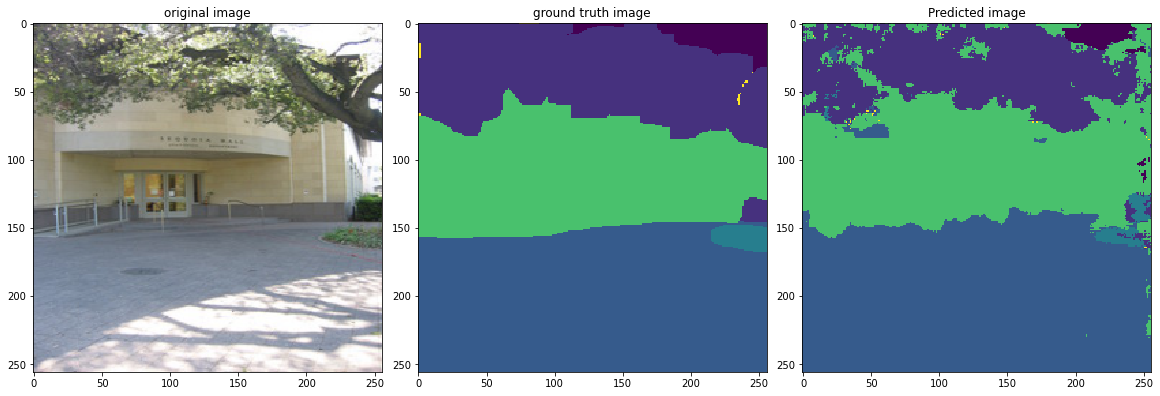

1/1 [==============================] - 0s 94ms/step


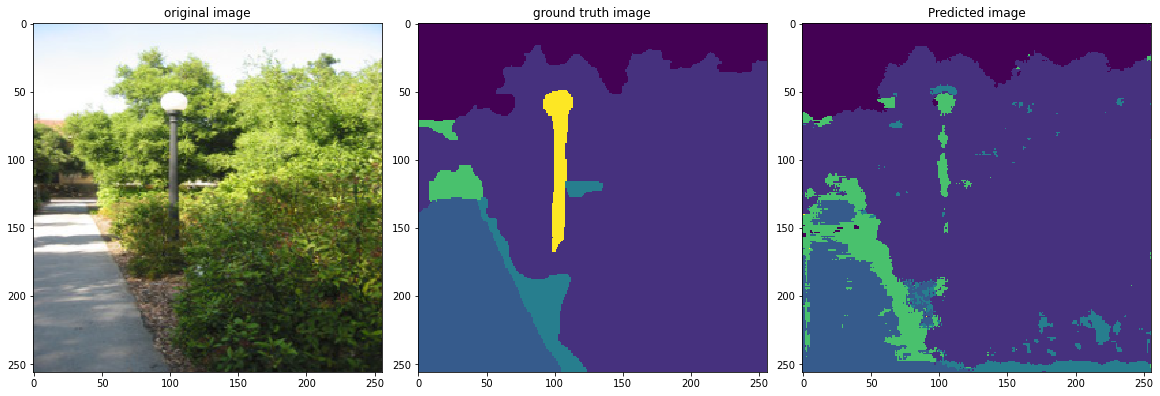

1/1 [==============================] - 0s 100ms/step


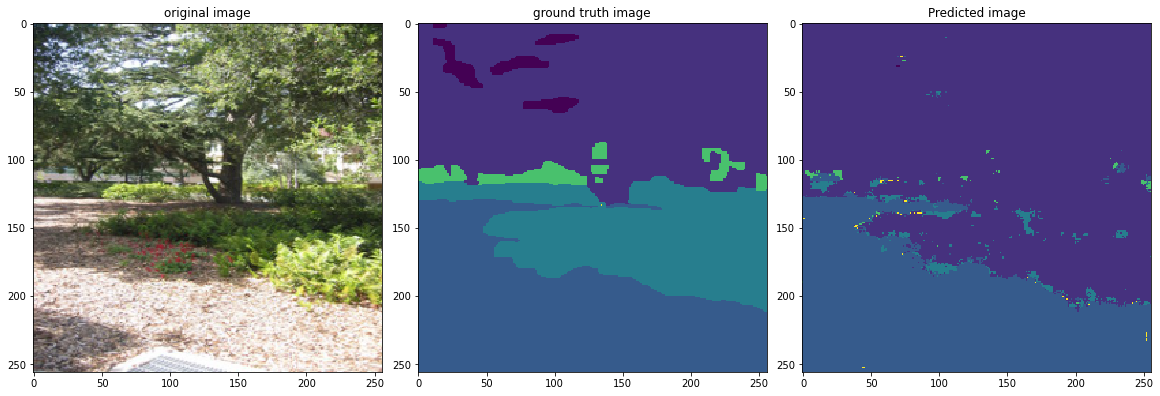

1/1 [==============================] - 0s 98ms/step


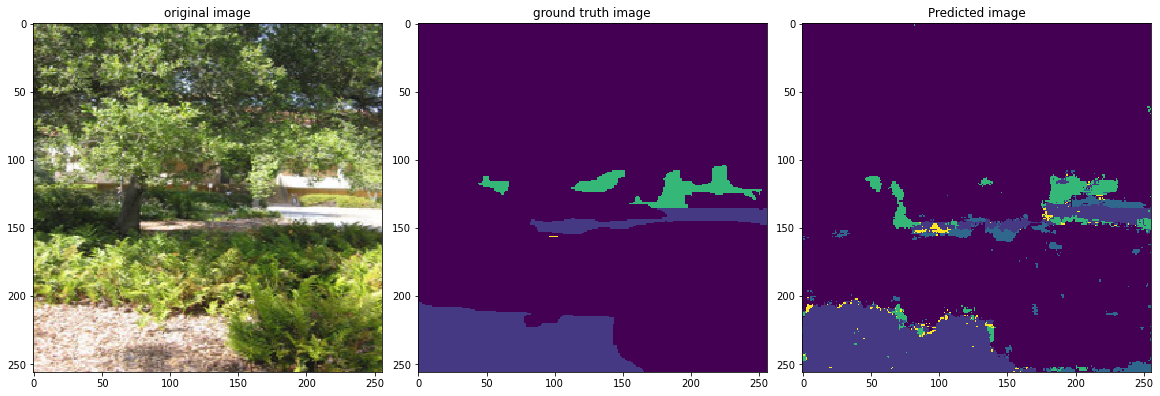

1/1 [==============================] - 0s 93ms/step


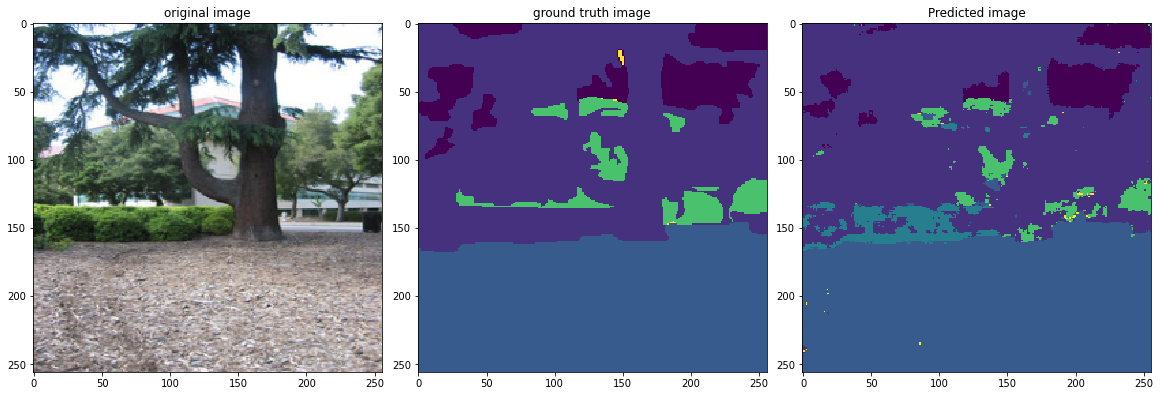

1/1 [==============================] - 0s 99ms/step


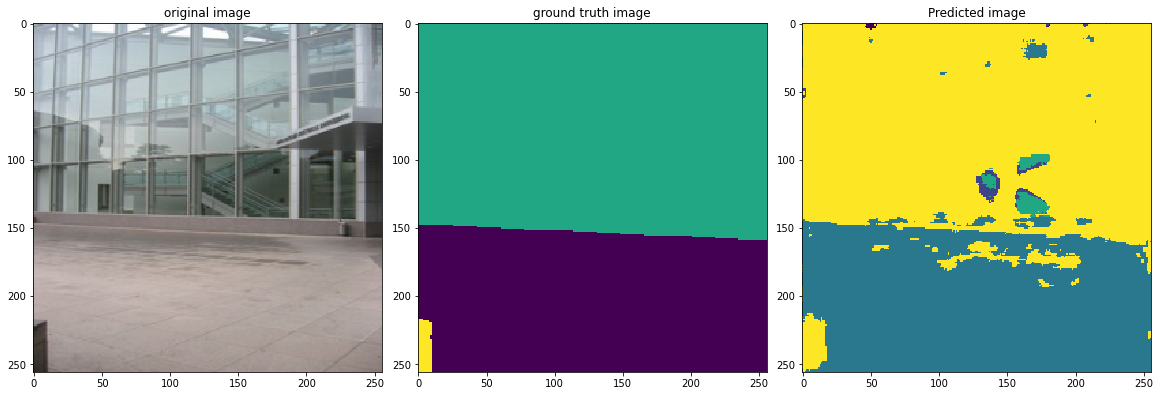

1/1 [==============================] - 0s 93ms/step


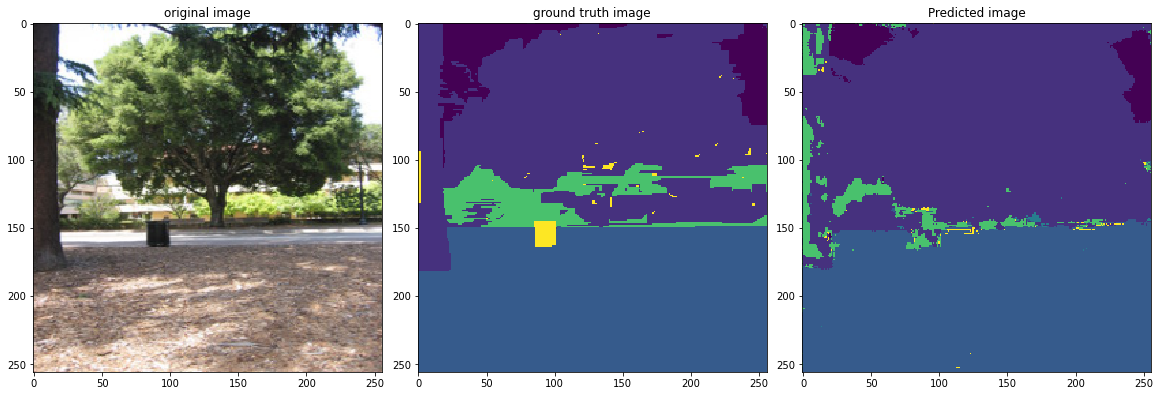

1/1 [==============================] - 0s 85ms/step


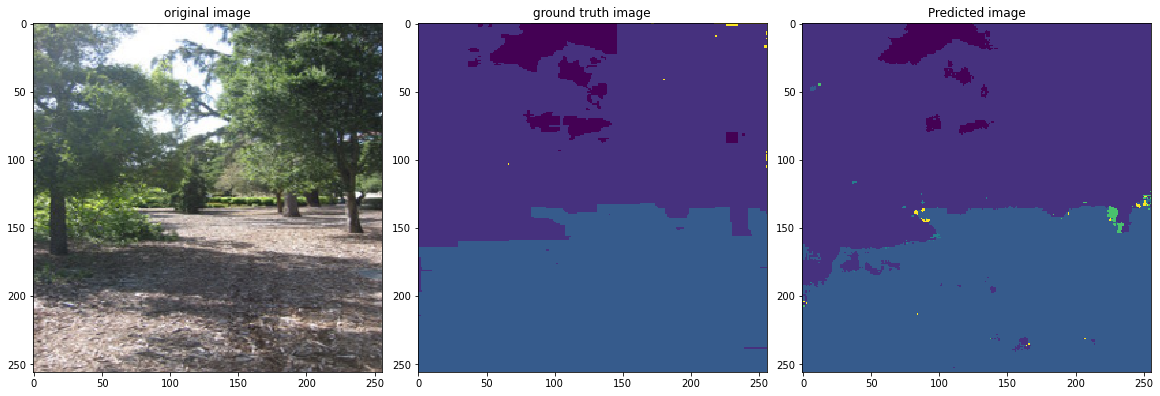

1/1 [==============================] - 0s 93ms/step


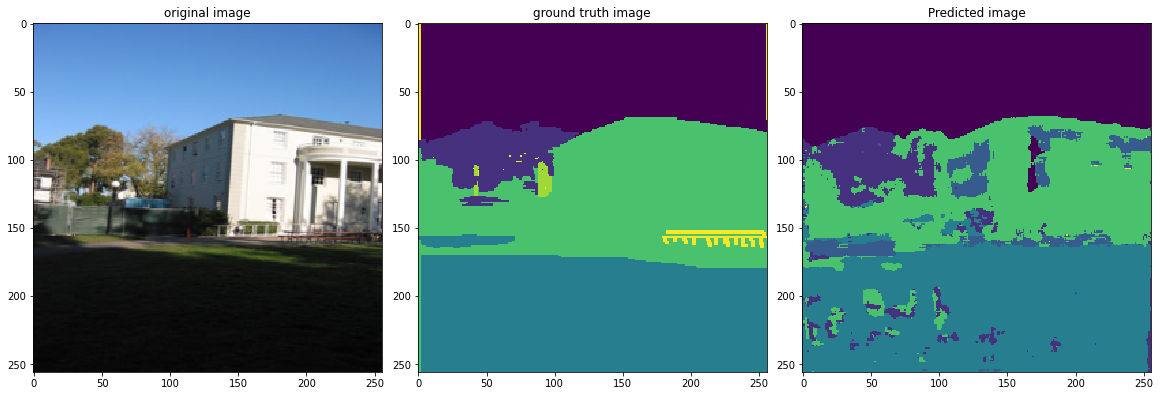

In [18]:
for i in range(10):
    test = next(val_gen)
    org = test[0][0]
    gt = test[1][0]
    gt = np.argmax(gt, axis=-1)
    prediction = model.predict(test[0])[0]
    pred_mask = tf.argmax(prediction, axis=-1)

    fig, axs = plt.subplots(1, 3, figsize=(16, 8), constrained_layout=True)

    axs[0].imshow(org, interpolation='none')
    axs[0].set_title('original image')
    axs[0].grid(False)

    axs[1].imshow(gt, interpolation='none' )#cmap='jet')
    axs[1].set_title('ground truth image')
    axs[1].grid(False)

    axs[2].imshow(pred_mask, interpolation='none')#cmap='jet')
    axs[2].set_title('Predicted image')
    axs[2].grid(False)

    plt.show()

    
    
    

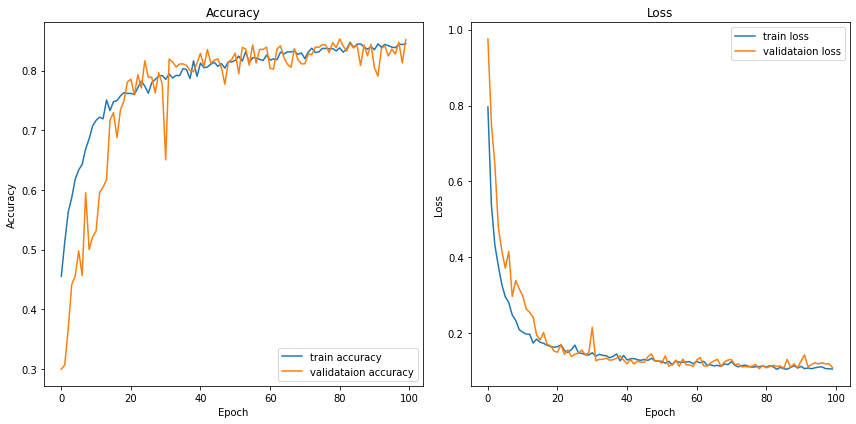

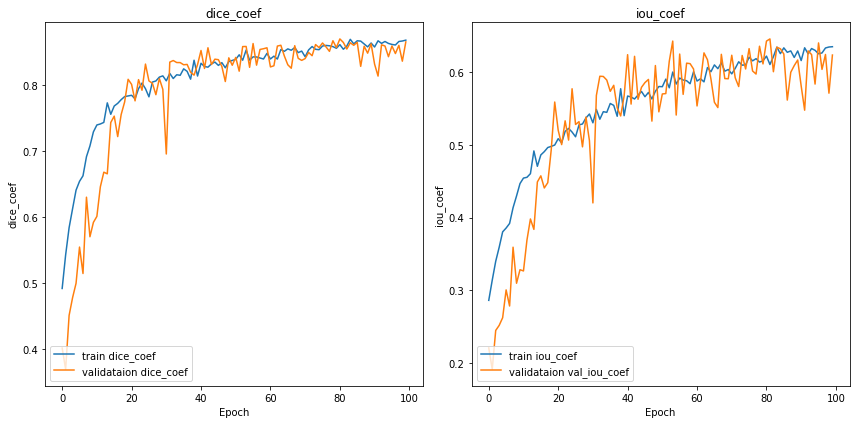

In [19]:
    def display_learning_curves(history):
        acc = history.history["accuracy"]
        val_acc = history.history["val_accuracy"]

        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        
        dice_coef = history.history["dice_coef"]
        val_dice_coef = history.history["val_dice_coef"]
        
        iou_coef = history.history["iou_coef"]
        val_iou_coef = history.history["val_iou_coef"]
        
        

        epochs_range = range(num_epochs)
        #print(epochs_range)
        fig = plt.figure(figsize=(12,6))

        plt.subplot(1,2,1)
        plt.plot(epochs_range, acc, label="train accuracy")
        plt.plot(epochs_range, val_acc, label="validataion accuracy")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc="lower right")

        plt.subplot(1,2,2)
        plt.plot(epochs_range, loss, label="train loss")
        plt.plot(epochs_range, val_loss, label="validataion loss")
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc="upper right")
        

        fig.tight_layout()
        
        
        fig1 = plt.figure(figsize=(12,6))
        
        plt.subplot(1,2,1)
        plt.plot(epochs_range, dice_coef, label="train dice_coef")
        plt.plot(epochs_range, val_dice_coef, label="validataion dice_coef")
        plt.title("dice_coef")
        plt.xlabel("Epoch")
        plt.ylabel("dice_coef")
        plt.legend(loc="lower left")
        
        plt.subplot(1,2,2)
        plt.plot(epochs_range, iou_coef, label="train iou_coef")
        plt.plot(epochs_range, val_iou_coef, label="validataion val_iou_coef")
        plt.title("iou_coef")
        plt.xlabel("Epoch")
        plt.ylabel("iou_coef")
        plt.legend(loc="lower left")
        
        fig1.tight_layout()
        plt.show()


    # Display learning curves 
    display_learning_curves(result)
    
    

1/1 [==============================] - 0s 83ms/step


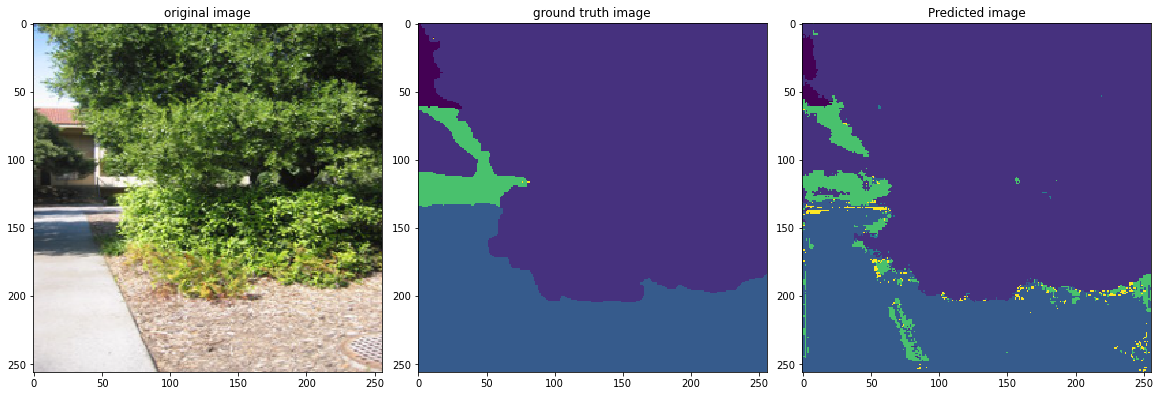

In [27]:
test = next(val_gen)
org = test[0][0]
gt = test[1][0]
gt = np.argmax(gt, axis=-1)
prediction = model.predict(test[0])[0]
pred_mask = tf.argmax(prediction, axis=-1)

fig, axs = plt.subplots(1, 3, figsize=(16, 8), constrained_layout=True)

axs[0].imshow(org, interpolation='none')
axs[0].set_title('original image')
axs[0].grid(False)

axs[1].imshow(gt, interpolation='none' )#cmap='jet')
axs[1].set_title('ground truth image')
axs[1].grid(False)

axs[2].imshow(pred_mask, interpolation='none')#cmap='jet')
axs[2].set_title('Predicted image')
axs[2].grid(False)

plt.show()


In [28]:
a = test[0][0] 
b = test[0]
c = a.reshape(-1,256,256,3)
print(a.shape)
print(b.shape)
print(c.shape)

(256, 256, 3)
(16, 256, 256, 3)
(1, 256, 256, 3)


In [29]:
with tf.device('/cpu:0'):
    from keract import get_activations
    activations = get_activations(model, c,'final')
    

In [30]:
[print(k, '->', v.shape, '- Numpy array') for (k, v) in activations.items()]


final -> (1, 256, 256, 8) - Numpy array


[None]

final (1, 256, 256, 8) 


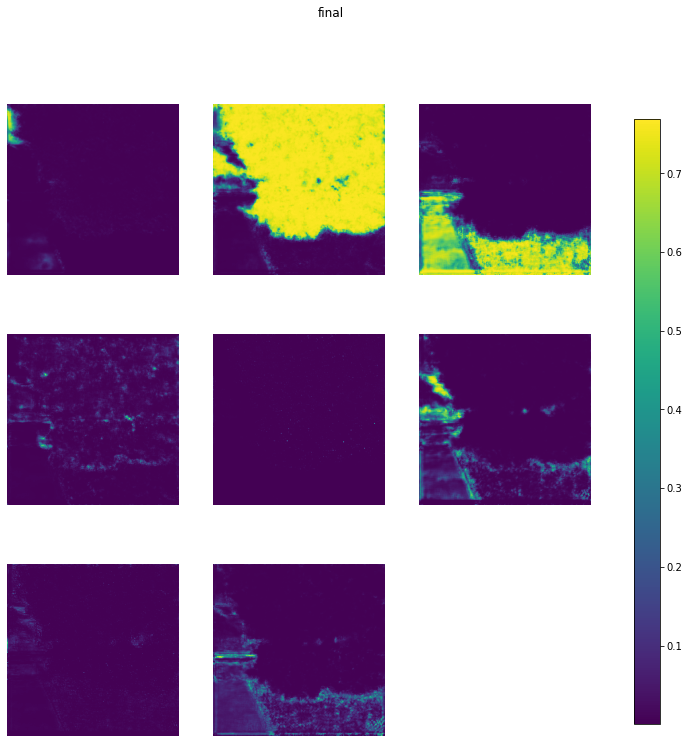

In [31]:
import keract
keract.display_activations(activations, cmap=None, save=False, directory='.', data_format='channels_last', fig_size=(12, 12), reshape_1d_layers=True)



final (1, 256, 256, 8) 


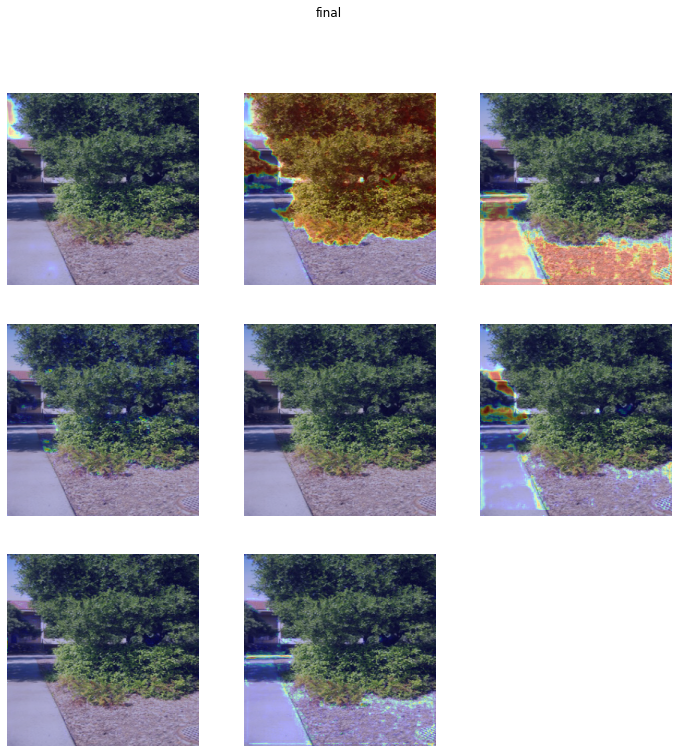

In [32]:
keract.display_heatmaps(activations, a, directory='.', save=False, fix=False, merge_filters=False)




## Miscellaneous code snippet for masked image use case


In [29]:
#For masked image use case
#For training
'''
Converts all images in a directory to '.npy' format.
Use np.save and np.load to save and load the images.
Use it for training your neural networks in ML/DL projects. 
'''

from PIL import Image
import os, sys
import cv2
import numpy as np



# Path to image directory
path = "/Users/User/Downloads/CV_conf/cvpr10Data/labels/"
dirs = os.listdir( path )
dirs.sort()

train_dirs = dirs[0:800]
test_dirs = dirs[800:1068]

x_train=[]
x_test=[]

# for item in train_dirs[0:2]:
#     if "regions" in item:
#         print(item)

def load_train_dataset():
    # Append images to a list
    for item in train_dirs:
        if "regions" in item:
            if os.path.isfile(path+item):
                im = np.loadtxt(path+item)
                print(im.shape)
                x_train.append(im)

load_train_dataset()

def load_test_dataset():
    # Append images to a list
    for item in test_dirs:
        if "regions" in item:
            if os.path.isfile(path+item):
                im = np.loadtxt(path+item)
                print(im.shape)
                x_test.append(im)

load_test_dataset()
print(len(x_train))
print(len(x_test))
# Convert and save the list of images into multiple '.npy' format files
imgset=np.array(x_train)
for i in range(len(imgset)):
    np.save("image_"+str(i)+".npy",imgset[i])


(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)
(320, 240)

In [26]:
#For testing
imgset=np.array(x_test)
for i in range(len(imgset)):
    np.save("image_"+str(i)+".npy",imgset[i])

In [27]:
#For training 
'''
Converts all images in a directory to '.npy' format.
Use np.save and np.load to save and load the images.
Use it for training your neural networks in ML/DL projects. 
'''

from PIL import Image
import os, sys
import cv2
import numpy as np



# Path to image directory
path = "/Users/User/Downloads/CV_conf/cvpr10Data/images/"
dirs = os.listdir( path )
dirs.sort()


train_dirs = dirs[0:400]
test_dirs = dirs[400:534]

x_train=[]
x_test=[]

def load_train_dataset():
    # Append images to a list
    for item in train_dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item).convert('RGB')
            im = np.array(im)
            print(im.shape)
            x_train.append(im)


def load_test_dataset():
    # Append images to a list
    for item in test_dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item).convert('RGB')
            im = np.array(im)
            print(im.shape)
            x_test.append(im)

            
load_train_dataset()
load_test_dataset()
    
# Convert and save the list of images into multiple '.npy' format files
imgset=np.array(x_train)
for i in range(len(imgset)):
    np.save("image_"+str(i)+".npy",imgset[i])

(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 240, 3)
(320, 

In [28]:
#For testing
imgset=np.array(x_test)
for i in range(len(imgset)):
    np.save("image_"+str(i)+".npy",imgset[i])

(320, 240, 3)
(320, 240)


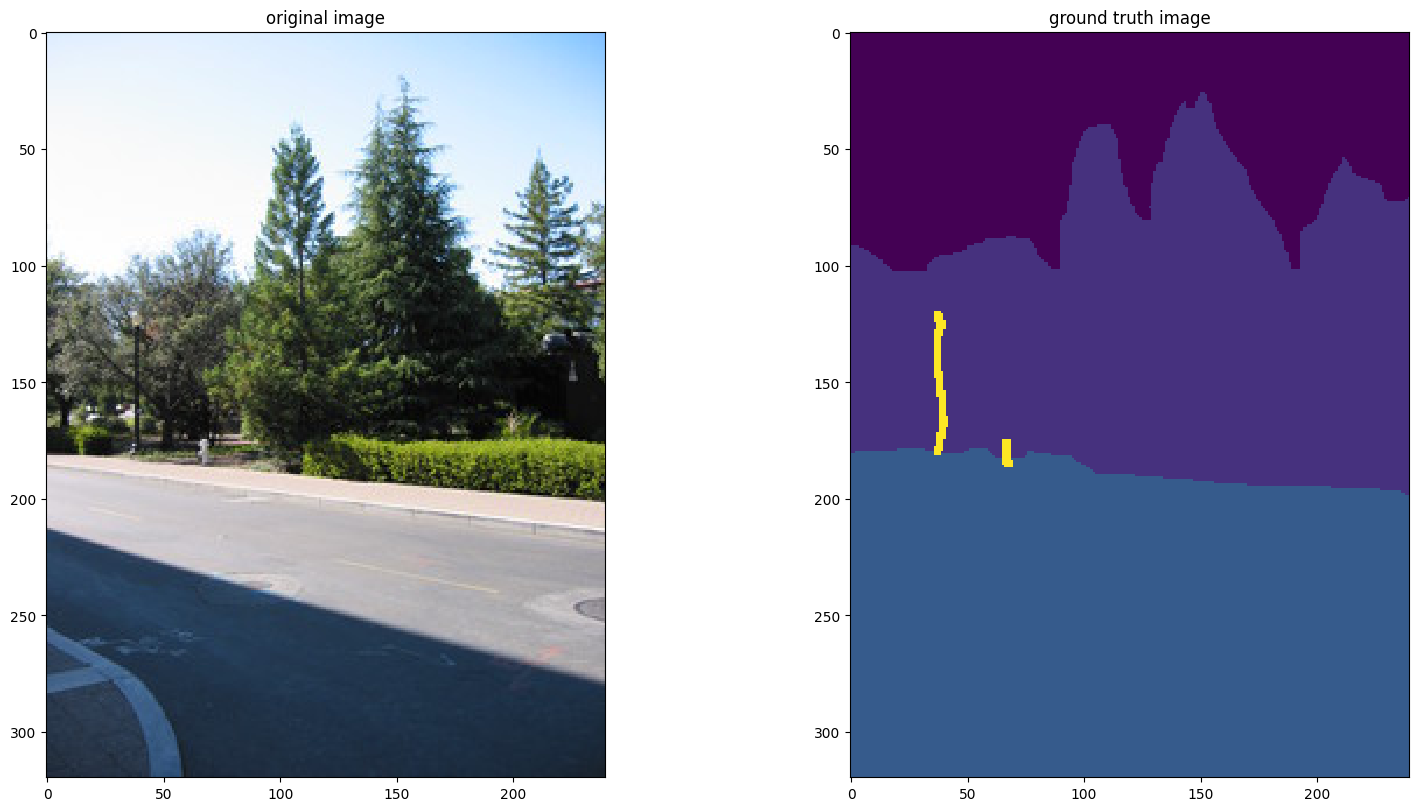

In [30]:
#Display a np arraay as image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

#read and display a color image (RGB) from mp array
#datanp= np.load("/Users/macbook/Downloads/Paper publishing /CV_conf/Semantic segmentation dataset/Tile 1/sample/imgds0.npy")
datanp1= np.load("/Users/macbook/Downloads/Paper publishing /CV_conf/cvpr10Data/training/train_frames_npy/image_1.npy")
datanp2= np.load("/Users/macbook/Downloads/Paper publishing /CV_conf/cvpr10Data/training/train_masks_npy/image_1.npy")
print(datanp1.shape)
print(datanp2.shape)


# imgnp = Image.fromarray(datanp, 'RGB')
# imgnp.show();
# plt.imshow(datanp1, interpolation='none')
# plt.imshow(datanp2, interpolation='none')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

axs[0].imshow(datanp1, interpolation='none')
axs[0].set_title('original image')
axs[0].grid(False)

axs[1].imshow(datanp2, interpolation='none' )#cmap='jet')
axs[1].set_title('ground truth image')
axs[1].grid(False)

plt.show()

In [36]:
#Code snippet used to identify the number of classes in the masked images of Semantic segmentation dataset
max = 0
for i in range(400):
    train_mask = np.load("/Users/macbook/Downloads/Paper publishing /CV_conf/cvpr10Data/training/train_masks_npy/image_"+str(i)+".npy")
    train_mask = cv2.resize(train_mask, (256,256), interpolation = cv2.INTER_NEAREST)
    #print(train_mask)
    #print(np.unique(train_mask))
    var = len(np.unique(train_mask))
    #print(var)
    if max < var:
        max = var
        print(max)
        print(i)
        print('----')
#     if i == 23:
#         print(train_mask)
#         print(np.unique(train_mask))
        


print(max)


5
0
----
6
2
----
7
6
----
8
84
----
8
